# 0. The dataset I choose is "heart_desease_uci".

In [4]:
!pip install kaggle
from google.colab import files
files.upload()
!kaggle datasets download -d andrewmvd/animal-crossing-new-horizons-nookplaza-catalog
import pandas as pd
heart_data = pd.read_csv("heart_disease_uci.csv")
heart_data.head()



Saving heart_disease_uci.csv to heart_disease_uci.csv
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


# 1. The column I choose for normal-gamma specification is "age".

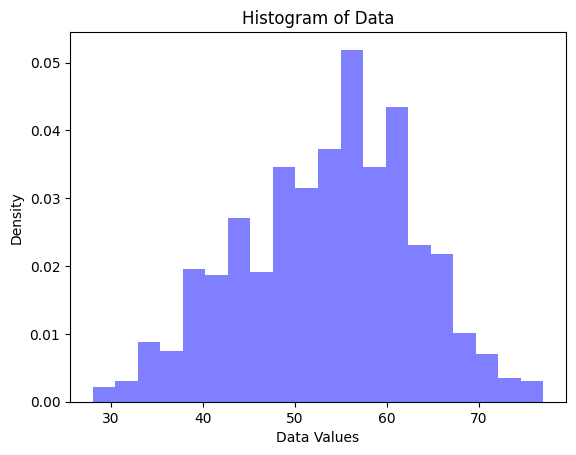

Standard Deviation: 9.419561705414813


/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


HMC Split-Rhats {'theta': 1.0012, 'phi': 1.0016} | MH Split-Rhats {'theta': 1.8752, 'phi': 1.2197}


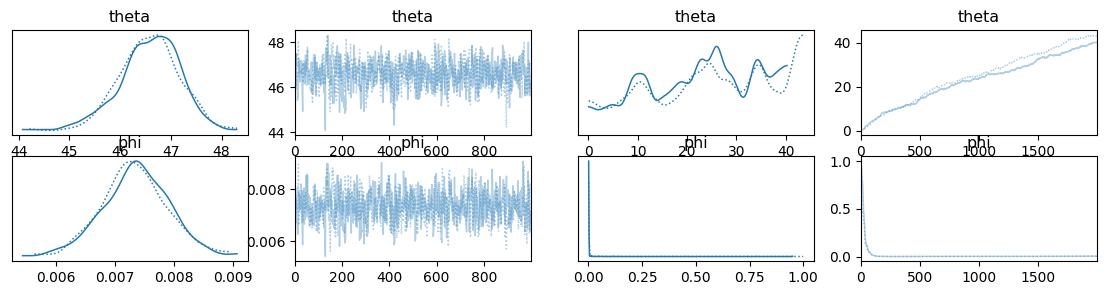

In [72]:
import pymc as pm
import numpy as np
import arviz as az
from scipy import stats
import matplotlib.pyplot as plt

# Plot histogram to visualize the distribution of the data
plt.hist(heart_data['age'], bins=20, density=True, alpha=0.5, color='blue')
plt.xlabel('Data Values')
plt.ylabel('Density')
plt.title('Histogram of Data')
plt.show()
sd = np.std(heart_data['age'])
print("Standard Deviation:", sd)



normal_gamma_toy_model = pm.Model()
# Define the PyMC model
with normal_gamma_toy_model:
    # Priors for the mean and precision
    theta = pm.Normal('theta', mu=0, sigma=1)  # Prior for the mean
    phi = pm.Gamma('phi', alpha=1, beta=1)      # Prior for the precision (inverse variance)

    # Likelihood (assuming 'column_name' is the column of interest)
    age_obs = pm.Normal("age_likelihood", mu=theta, sigma=1/phi**0.5, observed=heart_data['age'])

    idata_HMC = pm.sample() # default is the NUTS implementation of HMC

    MH = pm.Metropolis([theta, phi], S=np.array([0.1]), tune=False, tune_interval=0)
    idata_MH = pm.sample(step=MH) # force MH

fig,ax = plt.subplots(2,4, figsize=(14,3))
az.plot_trace(idata_HMC, axes=ax[:2,:2]); az.plot_trace(idata_MH, axes=ax[:2,2:])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | '); print('MH Split-Rhats',{k: np.round(v.values,4) for k,v in az.rhat(idata_MH).items()})

Autocorrelation for HMC (MCMC) chain 0.4967002312923211
Autocorrelation for MH (MCMC) chain 0.9991067380577853
number of MCMC samples: 2000
number of MCMC samples: 4000


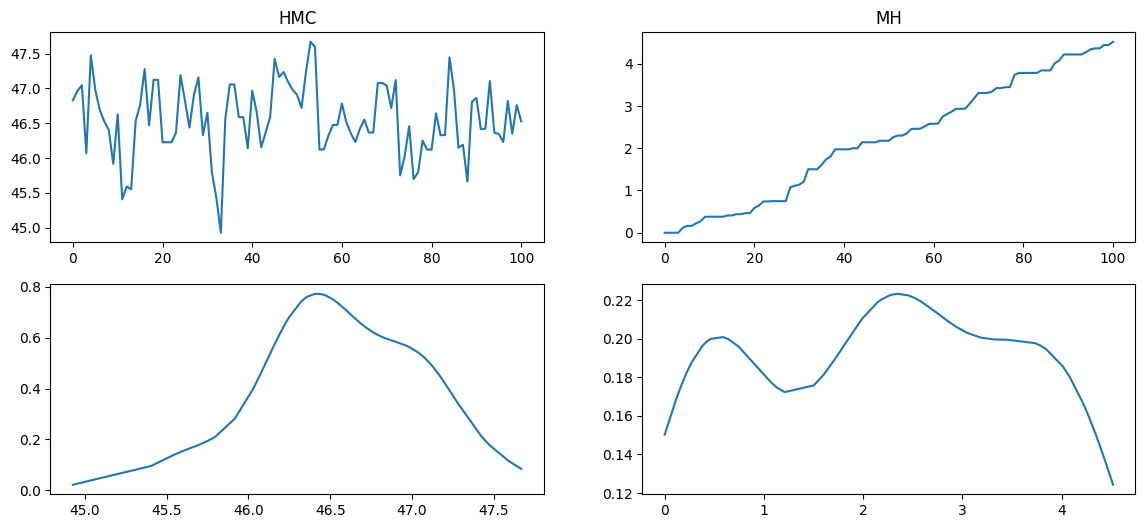

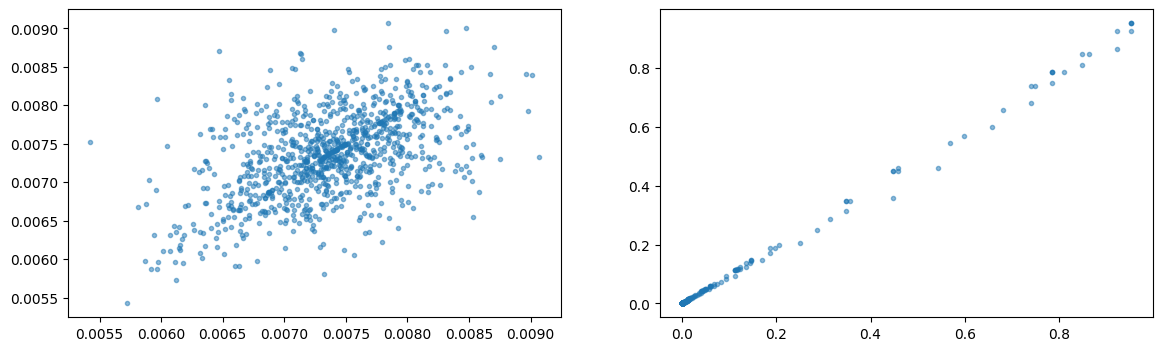

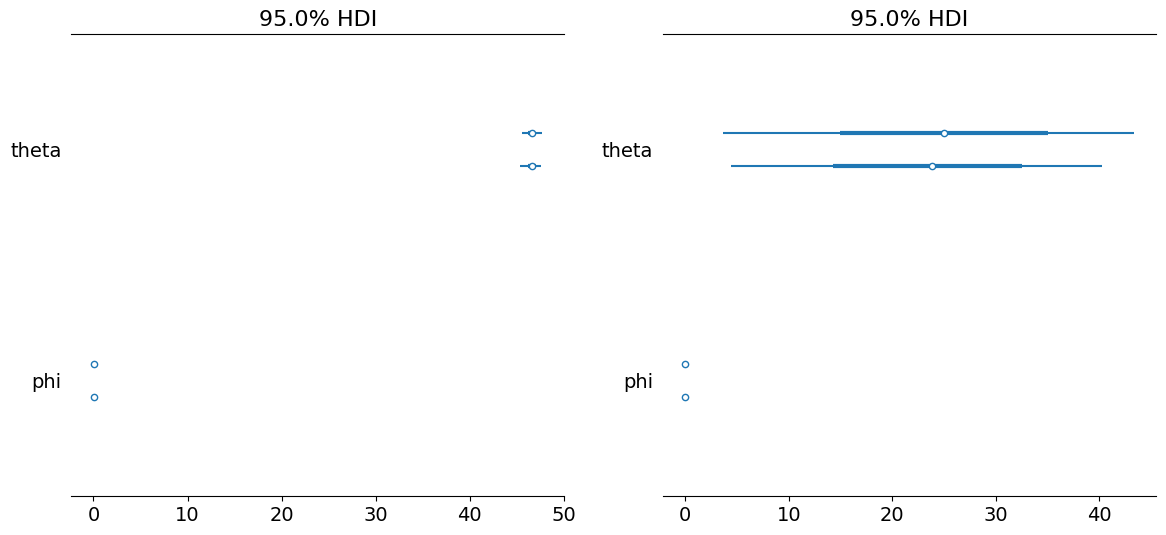

In [74]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import arviz as az


fig,ax = plt.subplots(2,2, figsize=(14,6))
n_mcmc_samples = 100
mcmc_chain = idata_HMC.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,0].plot(mcmc_chain); ax[1,0].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0,0].set_title("HMC");
mcmc_chain = idata_MH.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,1].plot(mcmc_chain); ax[1,1].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0,1].set_title("MH");


fig,ax = plt.subplots(1,2, figsize=(14,4))
max_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["phi"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = idata_HMC.posterior["phi"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[0].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])
mcmc_chain = idata_MH.posterior["phi"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = idata_MH.posterior["phi"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[1].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5);
print("Autocorrelation for MH (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])


print("number of MCMC samples:", idata_HMC.posterior['phi'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2)

print("number of MCMC samples:", idata_MH.posterior['phi'].values.flatten().shape[-1])
az.summary(idata_MH, round_to=2)

fig,ax = plt.subplots(1,2, figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["theta","phi"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_MH, var_names=["theta","phi"], combined=False, hdi_prob=0.95, ax=ax[1]);

In [68]:
print("number of MCMC samples:", idata_HMC.posterior['theta'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2)

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,51.76,0.23,51.35,52.22,0.01,0.0,1936.20,1294.45,1.0
phi,0.01,0.00,0.01,0.01,0.00,0.0,1936.26,1091.62,1.0


In [69]:
print("number of MCMC samples:", idata_MH.posterior['theta'].values.flatten().shape[-1])
az.summary(idata_MH, round_to=2)

number of MCMC samples: 4000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,51.77,0.34,51.19,52.33,0.04,0.03,101.71,63.48,1.01
phi,0.06,0.32,0.01,0.03,0.04,0.03,76.37,29.15,1.02


# 2&3. The "sex" column is one that normal-gamma specification is not justified because the "sex" column typically contains categorical data with only two levels. While the normal-gamma specification is typically used for continuous data where the mean (location parameter) follows a normal distribution and the precision (inverse variance) follows a gamma distribution. Instead, I use beta-bernoulli specification.

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:241: RuntimeWarning: invalid value encountered in divide
  self.scaling = tune(self.scaling, self.accepted_sum / float(self.tune_interval))


HMC Split-Rhats {'theta': 1.0011} | MH Split-Rhats {'theta': 1.6657}


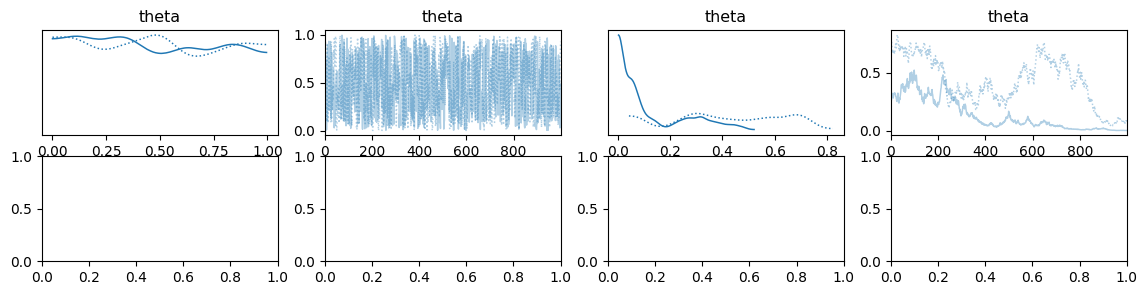

In [45]:
import pandas as pd
import pymc as pm
import arviz as az
from scipy import stats
import matplotlib.pyplot as plt

# Convert 'sex' column to numerical values (0 for Female, 1 for Male)
heart_data['sex_numeric'] = heart_data['sex'].map({'Female': 0, 'Male': 1})

beta_bernoulli_toy_model = pm.Model()
# Define the PyMC model with Bernoulli distribution
with beta_bernoulli_toy_model:
    # Prior for the probability of being male
    theta = pm.Beta('theta', alpha=1, beta=1)

    # Likelihood using Bernoulli distribution
    sex_obs = pm.Bernoulli('sex_obs', p=0.5, observed=heart_data['sex_numeric'])

    idata_HMC = pm.sample() # default is the NUTS implementation of HMC

    MH = pm.Metropolis([theta], S=np.array([0.1]), tune=False, tune_interval=0)
    idata_MH = pm.sample(step=MH) # force MH

fig,ax = plt.subplots(2,4, figsize=(14,3))
az.plot_trace(idata_HMC, axes=ax[:2,:2]); az.plot_trace(idata_MH, axes=ax[:2,2:])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | '); print('MH Split-Rhats',{k: np.round(v.values,4) for k,v in az.rhat(idata_MH).items()})

# 4. Posterior inference for the parameters using PyMC and analysis of the MCMC chains.

Autocorrelation for HMC (MCMC) chain 0.039243100074922876
Autocorrelation for MH (MCMC) chain 0.3189078206495499


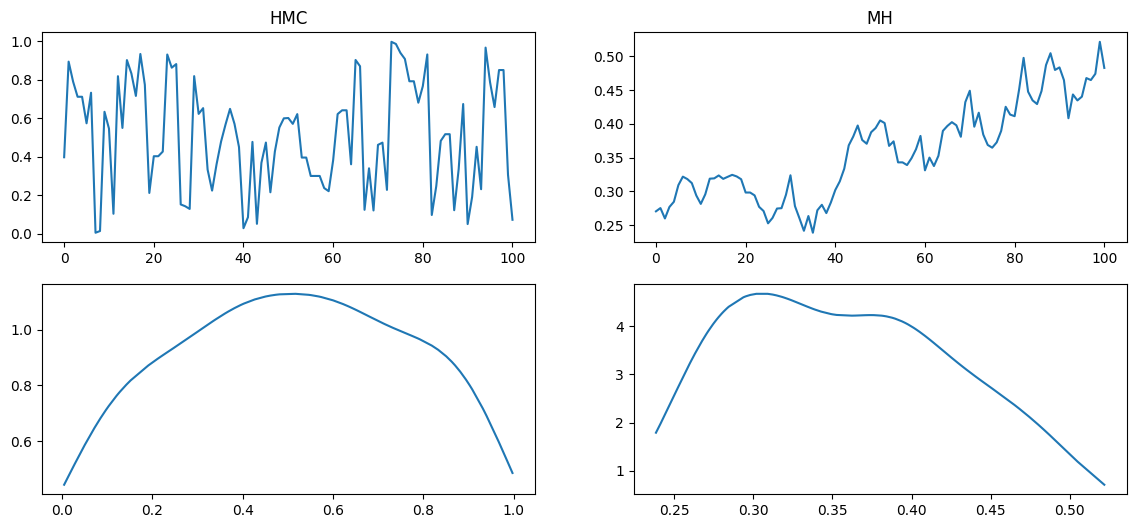

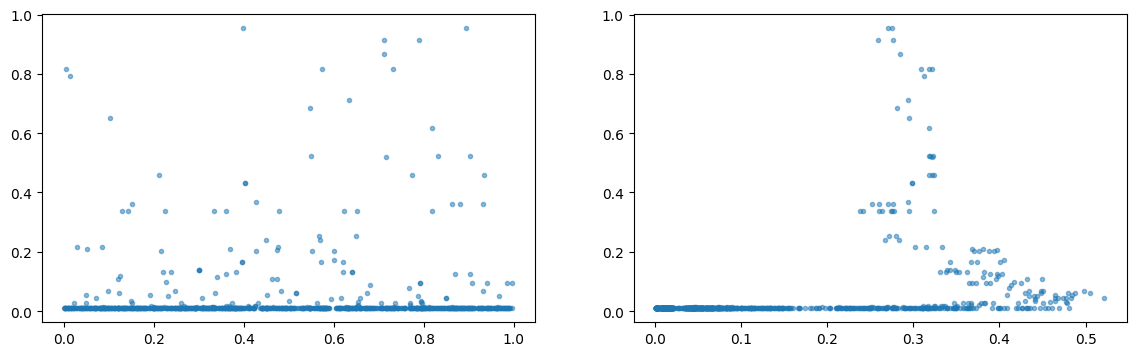

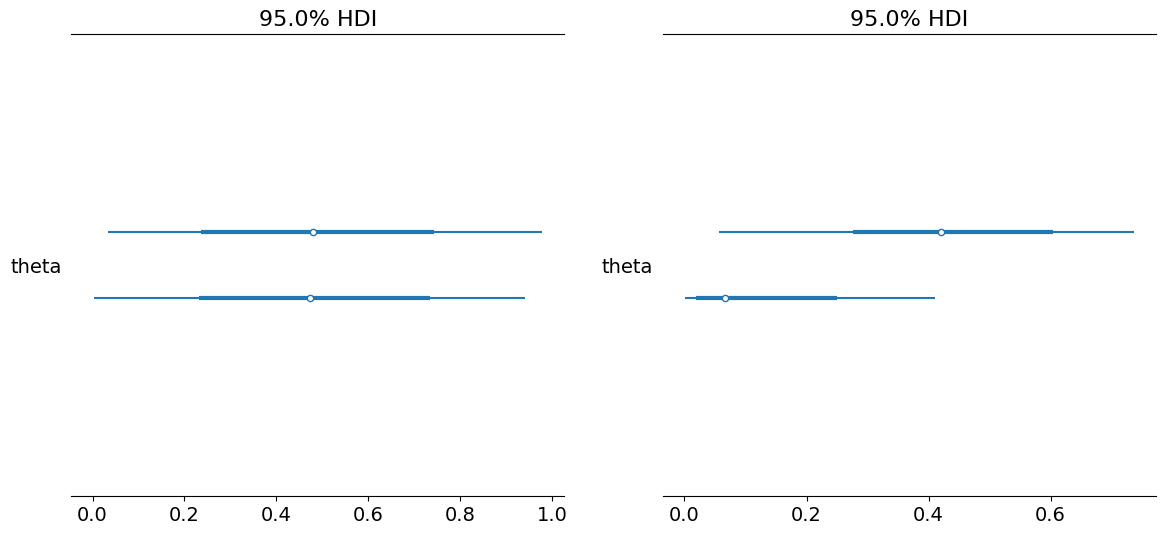

In [54]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

fig,ax = plt.subplots(2,2, figsize=(14,6))
n_mcmc_samples = 100
mcmc_chain = idata_HMC.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,0].plot(mcmc_chain); ax[1,0].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0,0].set_title("HMC");
mcmc_chain = idata_MH.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,1].plot(mcmc_chain); ax[1,1].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0,1].set_title("MH");

fig,ax = plt.subplots(1,2, figsize=(14,4))
max_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["theta"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; ax[0].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])
mcmc_chain = idata_MH.posterior["theta"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; ax[1].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5);
print("Autocorrelation for MH (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])


fig,ax = plt.subplots(1,2, figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_MH, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[1]);


In [53]:
print("number of MCMC samples:", idata_HMC.posterior['theta'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2)

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.49,0.29,0.0,0.93,0.01,0.01,913.4,1171.85,1.0


In [52]:
print("number of MCMC samples:", idata_MH.posterior['theta'].values.flatten().shape[-1])
az.summary(idata_MH, round_to=2)

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.28,0.23,0.0,0.69,0.12,0.09,3.27,11.77,1.67


Written by: Xihe Yu